## Results 1 - Hate Speech Detection

Let's check where the context really helps

In [40]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets
import glob
import json

train_dataset, dev_dataset, test_dataset = load_datasets(add_body=True)

evaluations = {
}


for model_name, glob_path in [
    ('no_context', "../evaluations/non-context*"),
    ('title', "../evaluations/context*"),
    ('hyphen', "../evaluations/title-hyphen*"),
    ('full_context', "../evaluations/title-body_*"),
    ]:
    evaluations[model_name] = []
    for path in glob.glob(glob_path):
        if "category" in path:
            continue
        with open(path) as f:
            obj = json.load(f)
            obj["file"] = path
            evaluations[model_name].append(obj)

print(f"We have {len(evaluations['full_context'])} title and body context evaluations")
print(f"We have {len(evaluations['title'])} title context evaluations")
print(f"We have {len(evaluations['hyphen'])} hyphen context evaluations")
print(f"We have {len(evaluations['no_context'])} no context evaluations")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
We have 15 title and body context evaluations
We have 15 title context evaluations
We have 6 hyphen context evaluations
We have 15 no context evaluations


In [41]:
sub_df[columns]

,precision,recall,f1,macro_f1
0,0.736139,0.613244,0.669095,0.806443
1,0.738368,0.609349,0.667683,0.805757
2,0.743198,0.623261,0.677966,0.811535
3,0.738786,0.623261,0.676124,0.810369
4,0.744898,0.609349,0.670340,0.807439
5,0.752917,0.610462,0.674247,0.809849
6,0.717602,0.619366,0.664875,0.803427
7,0.742240,0.612131,0.670936,0.807669
8,0.735748,0.610462,0.667275,0.805439
9,0.724115,0.614914,0.665062,0.803790


In [42]:
import pandas as pd

metric_columns = ["eval_precision", "eval_recall", "eval_f1", "eval_macro_f1"]

# We changed transformers in the middle and files changed. If error occurs, use these other columns
metric_columns_2 = ["test_precision", "test_recall", "test_f1", "test_macro_f1"]



dfs = []
for model_name, model_evaluations in evaluations.items():
    print(model_name)
    df = pd.DataFrame([
        {**{"file": evaluation["file"]}, **evaluation["metrics"]} for evaluation in model_evaluations
    ])

    print(df.columns)

    without_dash = model_name.replace("_", " ")

    try:
        df[metric_columns]
        columns = metric_columns
    except KeyError as e:
        columns = metric_columns_2

    sub_df = df[columns].copy()

    columns = [c.split("_", 1)[1] for c in sub_df.columns]

    sub_df.columns = columns
    
    mean_df = pd.DataFrame({
            f"{without_dash} mean": sub_df[columns].mean(), 
            f"{without_dash} std": sub_df[columns].std()
        })
    dfs.append(mean_df)

result_df = pd.concat(dfs, axis=1)

result_df

no_context
Index(['file', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_macro_f1',
       'eval_precision', 'eval_recall', 'eval_runtime',
       'eval_samples_per_second', 'init_mem_cpu_alloc_delta',
       'init_mem_gpu_alloc_delta', 'init_mem_cpu_peaked_delta',
       'init_mem_gpu_peaked_delta', 'test_mem_cpu_alloc_delta',
       'test_mem_gpu_alloc_delta', 'test_mem_cpu_peaked_delta',
       'test_mem_gpu_peaked_delta'],
      dtype='object')
title
Index(['file', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_macro_f1',
       'eval_precision', 'eval_recall', 'eval_runtime',
       'eval_samples_per_second', 'init_mem_cpu_alloc_delta',
       'init_mem_gpu_alloc_delta', 'init_mem_cpu_peaked_delta',
       'init_mem_gpu_peaked_delta', 'test_mem_cpu_alloc_delta',
       'test_mem_gpu_alloc_delta', 'test_mem_cpu_peaked_delta',
       'test_mem_gpu_peaked_delta'],
      dtype='object')
hyphen
Index(['file', 'test_loss', 'test_accuracy', 'test_f1', 'test_macro_f1',
       'test_precis

,no context mean,no context std,title mean,title std,hyphen mean,hyphen std,full context mean,full context std
precision,0.681722,0.019894,0.750523,0.011957,0.734209,0.019613,0.738500,0.008403
recall,0.593063,0.017633,0.603302,0.010823,0.608050,0.015612,0.615619,0.004930
f1,0.633848,0.005997,0.668799,0.007305,0.664859,0.005659,0.671448,0.004108
macro_f1,0.785066,0.003388,0.806790,0.004181,0.804037,0.003292,0.807807,0.002472


In [43]:
def print_mean(row, context, ):
    mean = row[context + " mean"]
    std = row[context + " std"]
    return f"${mean:.3f} \pm {std:.3f}$"

display_df = pd.DataFrame()

for context, model_name in [
    ("full context", "BERT Title+Body"), 
    ("title", "BERT Title"), 
    ("hyphen", "BERT Title-hyphen"),
    ("no context", "BERT No Context")]:
    display_df[model_name] = result_df.apply(lambda x: print_mean(x, context), axis=1)


display_df["metrics"] = display_df.index.map(lambda x: " ".join([y.capitalize() for y in x.split("_")]))
display_df.reset_index(inplace=True)
del display_df["index"]
display_df.set_index("metrics", inplace=True)
display_df.T


metrics,Precision,Recall,F1,Macro F1
BERT Title+Body,$0.738 \pm 0.008$,$0.616 \pm 0.005$,$0.671 \pm 0.004$,$0.808 \pm 0.002$
BERT Title,$0.751 \pm 0.012$,$0.603 \pm 0.011$,$0.669 \pm 0.007$,$0.807 \pm 0.004$
BERT Title-hyphen,$0.734 \pm 0.020$,$0.608 \pm 0.016$,$0.665 \pm 0.006$,$0.804 \pm 0.003$
BERT No Context,$0.682 \pm 0.020$,$0.593 \pm 0.018$,$0.634 \pm 0.006$,$0.785 \pm 0.003$


In [44]:
print(display_df.T.to_latex(escape=False, longtable=False))

\begin{tabular}{lllll}
\toprule
metrics &          Precision &             Recall &                 F1 &           Macro F1 \\
\midrule
BERT Title+Body   &  $0.738 \pm 0.008$ &  $0.616 \pm 0.005$ &  $0.671 \pm 0.004$ &  $0.808 \pm 0.002$ \\
BERT Title        &  $0.751 \pm 0.012$ &  $0.603 \pm 0.011$ &  $0.669 \pm 0.007$ &  $0.807 \pm 0.004$ \\
BERT Title-hyphen &  $0.734 \pm 0.020$ &  $0.608 \pm 0.016$ &  $0.665 \pm 0.006$ &  $0.804 \pm 0.003$ \\
BERT No Context   &  $0.682 \pm 0.020$ &  $0.593 \pm 0.018$ &  $0.634 \pm 0.006$ &  $0.785 \pm 0.003$ \\
\bottomrule
\end{tabular}



Hay que chequear qué pasa con los FP de no usar contexto

## ROC Curves

In [45]:
import torch 
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

data = []

auc_scores = {
    "None": [],
    "Title": [],
    "Hyphen": [],
    "Title+Body": [],
}

for context, evals in [
    ("None", evaluations["no_context"]), 
    ("Title", evaluations["title"]),
    ("Hyphen", evaluations["hyphen"]),
    ("Title+Body", evaluations["full_context"])]:

    for i, evaluation in enumerate(evals): 
        y_score = torch.softmax(torch.Tensor(evaluation["predictions"]), dim=1)[:, 1]
        y_true = torch.Tensor(evaluation["labels"])
        fpr, tpr, _ = roc_curve(y_true, y_score)
        
        score = roc_auc_score(y_true, y_score)
        auc_scores[context].append(score)

        this_points = []

        x_interp = np.arange(0, 1, 5e-3)
        y_interp = np.interp(x_interp, xp=fpr, fp=tpr)
        for x, y in zip(x_interp, y_interp):
            this_points.append({
                "fpr": x,
                "tpr": y,
                "context": context,
                "i": i,  
            })

        data += this_points

auc_scores = {k: np.array(v) for k, v in auc_scores.items()}

#plt.plot(fpr, tpr, color='darkorange',  lw=2)


#fpr, tpr, _ = roc_curve(y_true, y_score)

#plt.plot(fpr, tpr, color='blue', lw=2)

df = pd.DataFrame(data)

auc_scores

#

{'None': array([0.87486072, 0.84930613, 0.84437803, 0.82168292, 0.83630958,
        0.84775056, 0.87383485, 0.85375188, 0.84086879, 0.85919134,
        0.84555888, 0.84879591, 0.85899119, 0.84953482, 0.84927162]),
 'Title': array([0.88494751, 0.87095307, 0.88615019, 0.88745501, 0.89191944,
        0.88843742, 0.89357883, 0.88596896, 0.87448684, 0.89229206,
        0.89333682, 0.8951755 , 0.88694758, 0.88891588, 0.88545482]),
 'Hyphen': array([0.88994059, 0.88391485, 0.88562443, 0.86333156, 0.87651268,
        0.8807348 ]),
 'Title+Body': array([0.89055277, 0.88502985, 0.88828793, 0.89682335, 0.89063159,
        0.89319939, 0.88714882, 0.89577585, 0.88582884, 0.889928  ,
        0.8910871 , 0.88690532, 0.89196482, 0.89151904, 0.88976661])}

In [46]:
print("AUC SCORES")

for k, v in auc_scores.items():
    print(f"{k:<15}: {v.mean():.3f} +- {v.std():.3f}")

AUC SCORES
None           : 0.850 +- 0.013
Title          : 0.887 +- 0.006
Hyphen         : 0.880 +- 0.009
Title+Body     : 0.890 +- 0.003


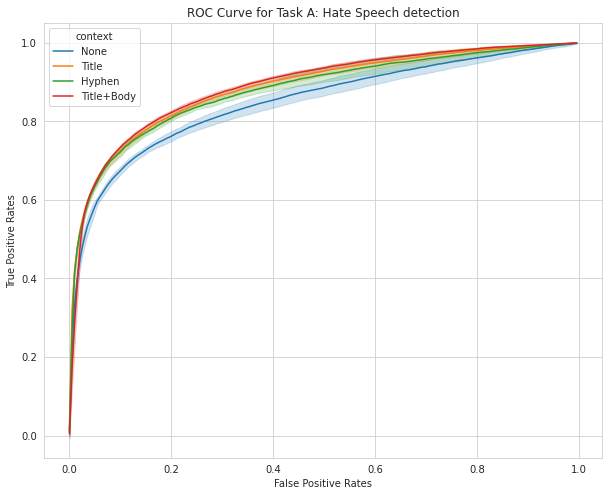

In [47]:

sns.set_style("whitegrid")
#p = df[(df["context"] == "none") & (df["i"] <= 1)]
g = sns.lineplot(data=df, x="fpr", y="tpr", hue="context", ci="sd")

plt.title("ROC Curve for Task A: Hate Speech detection")
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
g.figure.set_figwidth(10)
g.figure.set_figheight(8)


## Confusion matrices

In [53]:
from sklearn.metrics import confusion_matrix
evaluation = evaluations["no_context"][0]
y_pred = torch.argmax(torch.Tensor(evaluation["predictions"]), dim=1)
y_true = torch.Tensor(evaluation["labels"])

confusion_matrix(y_true, y_pred)

array([[9027,  519],
       [ 703, 1094]])

In [54]:
import torch 
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

data = []

cms = {
    "None": [],
    "Title": [],
    "Hyphen": [],
    "Title+Body": [],
}

for context, evals in [
    ("None", evaluations["no_context"]), 
    ("Title", evaluations["title"]),
    ("Hyphen", evaluations["hyphen"]),
    ("Title+Body", evaluations["full_context"])]:

    for i, evaluation in enumerate(evals): 
        y_pred = torch.argmax(torch.Tensor(evaluation["predictions"]), dim=1)
        y_true = torch.Tensor(evaluation["labels"])
        
        cm = confusion_matrix(y_true, y_pred)
        cms[context].append(cm)

In [92]:


annot

9154.066666666668 17.517483330153972
391.93333333333334 17.517483330153972
690.7333333333333 8.559335384375485
1106.2666666666667 8.559335384375485


[['9154.1 +- 17.5', '391.9 +- 17.5'], ['690.7 +- 8.6', '1106.3 +- 8.6']]

((2, 2), (2, 2))

<AxesSubplot:>

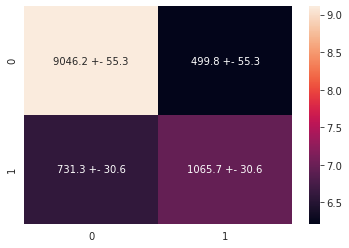

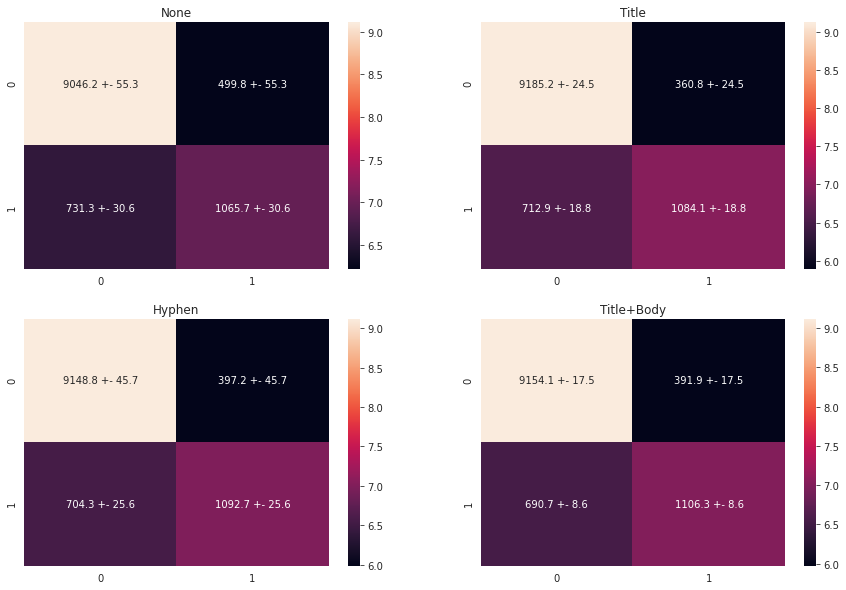

In [105]:
i = 0
plt.figure(figsize=(15, 10))
for context, matrices in cms.items():
    i += 1
    """
    Obtengo las anotaciones, perdón el quilombo
    """
    cm_avg, cm_std = np.array(matrices).mean(0), np.array(matrices).std(0)

    annot = []
    for rmu, rstd in zip(cm_avg, cm_std):
        row = []
        for mu, std in zip(rmu, rstd):
            row.append(f"{mu:.1f} +- {std:.1f}")
        annot.append(row)
    plt.subplot(2, 2, i)
    plt.title(context)
    sns.heatmap(np.log(cm_avg), annot=np.array(annot), fmt="")